In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


QUESTION 1 - Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

In [2]:
df = pd.read_csv("ratings_Electronics.csv",  names=["user_id", "prod_id", "ratings", "timestamp"])

In [3]:
df.head(5)

,user_id,prod_id,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
df.shape

(7824482, 4)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [6]:
ratings_df = df.drop(columns = "timestamp")
ratings_df.head()

,user_id,prod_id,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


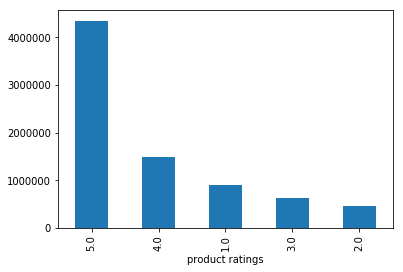

In [7]:
ratings_df['ratings'].value_counts().plot(kind = 'bar')
plt.xlabel('product ratings')
plt.show()

In [8]:
ratings_df['ratings'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: ratings, dtype: int64

Lookd like the data distribution is mpre on the 5 star raiting 

In [9]:
len(ratings_df["user_id"].unique().tolist())

4201696

42 lakhs users are present , now looking at the number of unique products

In [10]:
len(ratings_df["prod_id"].unique().tolist())

476002

47 lakh unique product are present

QUESTION 2 - Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )

In [11]:
users_cnt = ratings_df['user_id'].value_counts()
ratings_df_filt = ratings_df[ratings_df['user_id'].isin(users_cnt[users_cnt>=50].index)]
ratings_df_filt.shape

(125871, 3)

In [12]:
len(ratings_df_filt["user_id"].unique().tolist())

1540

QUESTION 3 - Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

In [13]:
from surprise.model_selection import train_test_split
from surprise.reader import Reader
from surprise import Dataset

In [14]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings_df_filt[['user_id', 'prod_id', 'ratings']], reader)

In [15]:
trainset, testset = train_test_split(data, test_size=0.3)

QUESTION 4 - Build Popularity Recommender model

In [16]:
ratings_df_filt.groupby('prod_id')['ratings'].mean().head()

prod_id
0594451647    5.000000
0594481813    3.000000
0970407998    2.500000
0972683275    4.750000
1400501466    3.333333
Name: ratings, dtype: float64

making a dataframe with average ratings 

In [17]:
ratings_df_filt.groupby('prod_id')['ratings'].count().sort_values(ascending=False).head()

prod_id
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: ratings, dtype: int64

In [18]:
ratings_mean_count = pd.DataFrame(ratings_df_filt.groupby('prod_id')['ratings'].mean()) 

In [19]:
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings_df_filt.groupby('prod_id')['ratings'].count())  
ratings_mean_count.head()

,ratings,rating_counts
prod_id,,
0594451647,5.000000,1
0594481813,3.000000,1
0970407998,2.500000,2
0972683275,4.750000,4
1400501466,3.333333,6


In [20]:
ratings_mean_count = ratings_mean_count.sort_values(by = 'rating_counts', ascending = False)

The dataframe is  now arranged in descending order we can plot the graphs and analyze the data

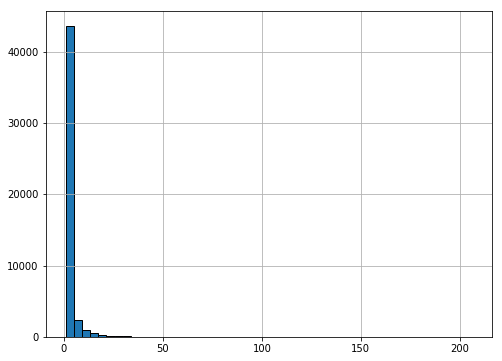

In [21]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

Most of the products have raiting lesss than 50 

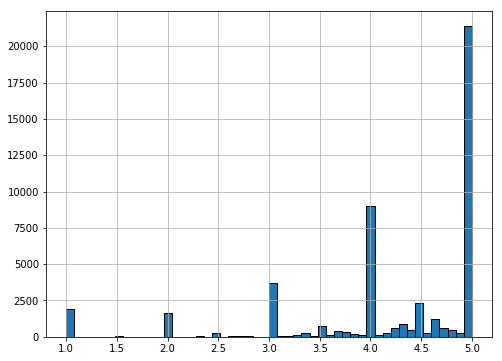

In [22]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['ratings'].hist(bins=50)

From the plot from the aboove for average ratings , the whole number have a huge list of raitings compared to the decimal values 

<Figure size 576x432 with 0 Axes>

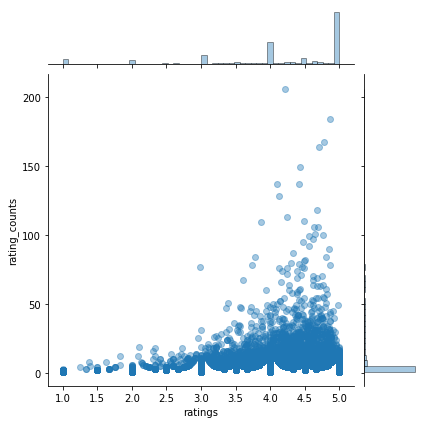

In [23]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='ratings', y='rating_counts', data=ratings_mean_count, alpha=0.4)

Now the top 5 trending products are 

In [24]:
popularity_based_RS = ratings_mean_count
popularity_based_RS.head(10)

,ratings,rating_counts
prod_id,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149
B008DWCRQW,4.094891,137
B00829THK0,4.416058,137
B002R5AM7C,4.125000,128
B004CLYEDC,4.669492,118


QUESTION 5 - Build Collaborative Filtering model

In [25]:
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.reader import Reader

Building a 'USER-USER' Collaborative Model

Training the model and running it with the test data set

In [26]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [27]:
test_pred = algo.test(testset)

In [28]:
test_pred

[Prediction(uid='A19FRW264WZTGP', iid='B001S4OTS6', r_ui=5.0, est=3.7911977994498627, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='ADKGE078JK8K7', iid='B004D954BE', r_ui=1.0, est=4.26022313271062, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3UXW18DP4WSD6', iid='B001EHRTNE', r_ui=5.0, est=4.26022313271062, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='ANTN61S4L7WG9', iid='B009PK9S90', r_ui=5.0, est=4.423234752275003, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid='AT8V3JOZD3KWK', iid='B00889ST2G', r_ui=5.0, est=4.25, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1FDV3WPOHREY9', iid='B00894YP00', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AVJORH3ACR2A5', iid='B001UE6MAM', r_ui=5.0, est=4.630434782608695, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A21I62TCDL4754'

QUESTION 6 - Evaluate both the models (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [29]:
accuracy.rmse(test_pred, verbose=True)

RMSE: 1.0528


1.052774529507035

The above is the RMSE for Collaborative Mode , for popularity based model RMSE cannot be applied 

QUESTION 7 - Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [30]:
from collections import defaultdict

In [31]:
def get_top_n(test_pred, n):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_x, est, _ in test_pred:
        top_n[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, ratings_df_filt in top_n.items():
        ratings_df_filt.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = ratings_df_filt[:n]
        
    return top_n

In [32]:
get_top_n(test_pred, 5)

defaultdict(list,
            {'A19FRW264WZTGP': [('B003ULNA3K', 5),
              ('B004DMNT2W', 5),
              ('B001T9NUJE', 4.9589643486430095),
              ('B0049U3TVE', 4.607918099399097),
              ('B005HY4U5A', 4.592748845466666)],
             'ADKGE078JK8K7': [('B001RB21JY', 4.702702702702703),
              ('B003HIXOOG', 4.702702702702703),
              ('B002L6HE6E', 4.702702702702703),
              ('B007U5MGDC', 4.702702702702703),
              ('B00005N6KG', 4.702702702702703)],
             'A3UXW18DP4WSD6': [('B003ES5ZUU', 5),
              ('B005FYNSPK', 4.861111111111111),
              ('B000I20AJ6', 4.861111111111111),
              ('B002O21XHQ', 4.861111111111111),
              ('B005BL4PHW', 4.861111111111111)],
             'ANTN61S4L7WG9': [('B006K553LU', 5),
              ('B00BEHQKP2', 4.96257361003555),
              ('B008ULPD0S', 4.919148936170212),
              ('B007ZZ6OW6', 4.900179547767669),
              ('B00CKAOJA0', 4.89538568697

QUESTION 8 - Summarise your insights

A Collaborative model provide customized reccomendation for each user but it cannot be used for new users as for a new user no data is being generated and hence there wont be any recommendation

The Popularity based recommendation list provide the same list of recommendation for a particular user at any given time which means no new products will be recommended to him 

An RMSE value of 1.05 has been obtained for the user-user Collaborative model